**Notebook of Saskia Dwi Ulfah**

# **0. CONNECT TO GOOGLE DRIVE**

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
GDRIVE_PATH = '/content/gdrive/MyDrive/Indonesia AI/CV Course/Final Project/'

# **1. IMPORT LIBRARIES**

In [4]:
import os
import glob
import random
import cv2
import numpy as np

import tensorflow as tf
from keras.utils import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# **2. DATA PREPROCESSING**

## *Resize image dataset and determine number of classes*

In [5]:
# Resize image dataset & determine number of classes
SIZE_X = 256 
SIZE_Y = 256
n_classes = 12

## *Get images and masks for training*

In [6]:
# Get image train dataset
train_images = []

for directory_path in glob.glob(GDRIVE_PATH + "sample_city_landscape/images_prepped_train/"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
# Convert list to array for machine learning processing
train_images = np.array(train_images)

In [7]:
# Get image label/annotations dataset for training

train_masks = [] 
for directory_path in glob.glob(GDRIVE_PATH + "sample_city_landscape/annotations_prepped_train/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST) # Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
               
train_masks = np.array(train_masks)

## *Get images and masks for testing*

In [8]:
# Get image test dataset

test_images = []

for directory_path in glob.glob(GDRIVE_PATH + "sample_city_landscape/images_prepped_test/"):
  for img_path in glob.glob(os.path.join(directory_path, "*.png")):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    test_images.append(img)

test_images = np.array(test_images)

In [9]:
# Get image label/annotations dataset for test

test_masks = [] 
for directory_path in glob.glob(GDRIVE_PATH + "sample_city_landscape/annotations_prepped_test/"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST) # Otherwise ground truth changes due to interpolation
        test_masks.append(mask)
               
test_masks = np.array(test_masks)

## *Implement LabelEncoder for training data*

In [10]:
# Implement LabelEncoder: convert semantic labels to one-hot encoding

le = LabelEncoder()

n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = le.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3) # Final input masks

train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1) # Final input images

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Check after some transformations

print(train_masks_reshaped.shape)
print(train_masks_reshaped_encoded.shape)
print(train_masks_encoded_original_shape.shape)
print(train_masks_input.shape) # Final
print('')
print(train_images.shape) # Final

(24051712, 1)
(24051712,)
(367, 256, 256)
(367, 256, 256, 1)

(367, 256, 256, 1)


## *Implement LabelEncoder for testing data*

In [12]:
# Implement LabelEncoder: convert semantic labels to one-hot encoding

a, b, c = test_masks.shape
test_masks_reshaped = test_masks.reshape(-1,1)
test_masks_reshaped_encoded = le.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(a, b, c)
test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3) # Final masks

test_images = np.expand_dims(test_images, axis=3)
test_images = normalize(test_images, axis=1) # Final images

In [13]:
# Check after some transformations

print(test_masks_reshaped.shape)
print(test_masks_reshaped_encoded.shape)
print(test_masks_encoded_original_shape.shape)
print(test_masks_input.shape) # Final
print('')
print(test_images.shape) # Final

(6619136, 1)
(6619136,)
(101, 256, 256)
(101, 256, 256, 1)

(101, 256, 256, 1)


## *Split dataset*

In [14]:
# Split dataset

X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks_input, test_size=0.15, random_state=42)
X_test, X1, y_test, y1 = train_test_split(test_images, test_masks_input, test_size=0.15, random_state=42)

print('Class values in the dataset are ...', np.unique(y_train))

Class values in the dataset are ... [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('')
print(X_test.shape)
print(y_test.shape)
print(X1.shape)
print(y1.shape)

(311, 256, 256, 1)
(311, 256, 256, 1)
(56, 256, 256, 1)
(56, 256, 256, 1)

(85, 256, 256, 1)
(85, 256, 256, 1)
(16, 256, 256, 1)
(16, 256, 256, 1)


In [16]:
# Transformation into 12 channels

# final for training
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

# final for validation
val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

# final for testing
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [17]:
print(train_masks_cat.shape)
print(y_train_cat.shape)
print('')
print(val_masks_cat.shape)
print(y_val_cat.shape)
print('')
print(test_masks_cat.shape)
print(y_test_cat.shape)

(311, 256, 256, 12)
(311, 256, 256, 12)

(56, 256, 256, 12)
(56, 256, 256, 12)

(85, 256, 256, 12)
(85, 256, 256, 12)


# **3. U-Net Implementation**

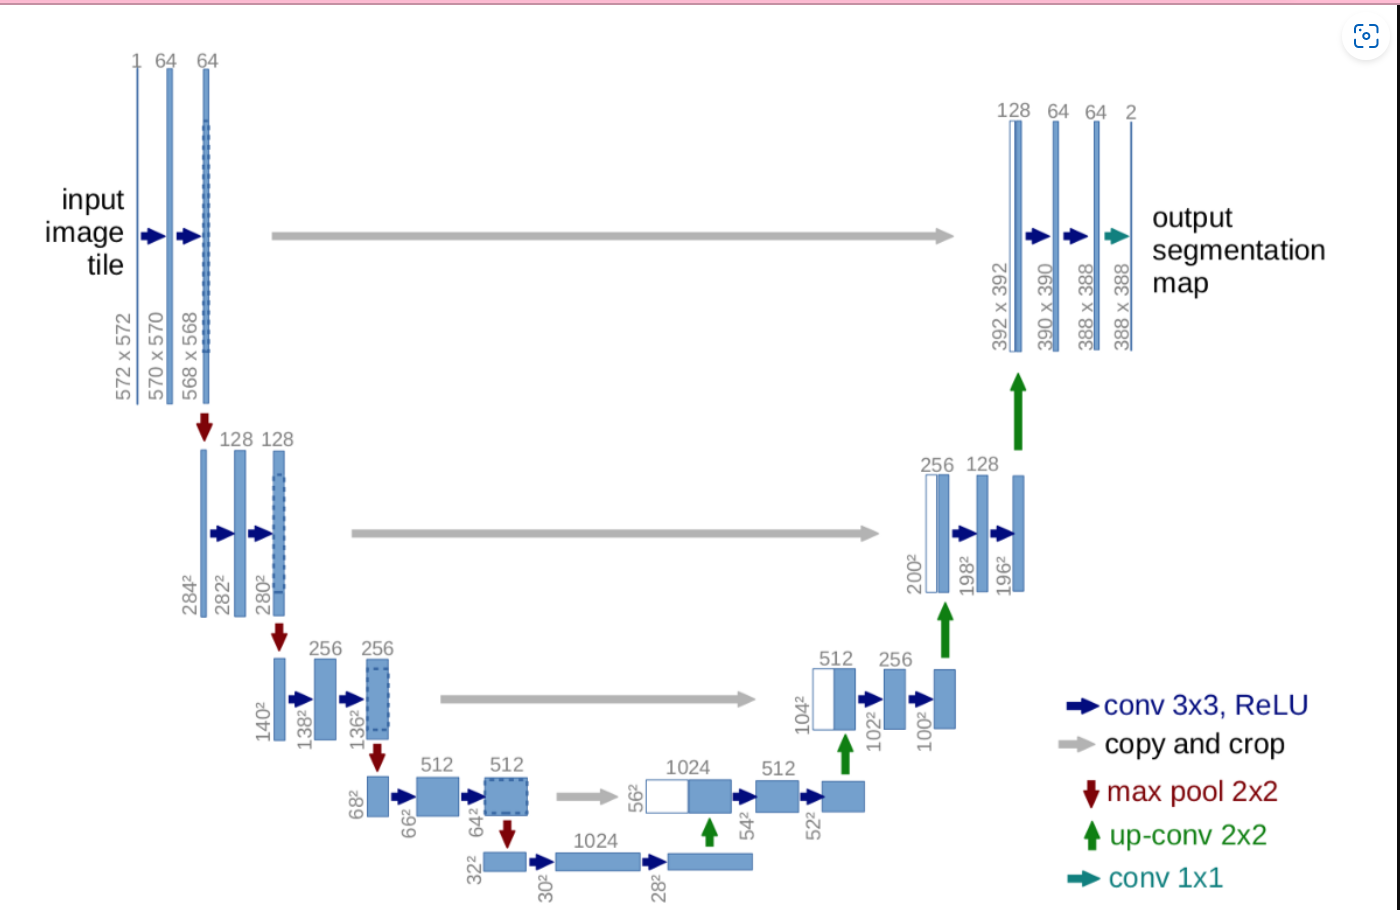

In [18]:
from keras.layers.pooling.max_pooling1d import MaxPooling1D
# Design U-Net architecture
def multi_unet_model(n_classes=12, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)
 
    # Bottleneck
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1,1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [19]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
  return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [20]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [21]:
# Train model

filepath = '/content/gdrive/MyDrive/Indonesia AI/CV Course/Final Project/checkpoints/uNet.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
early_stopping = EarlyStopping(    
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

callbacks = [checkpoint, early_stopping]

history = model.fit(X_train, 
                    y_train_cat, 
                    batch_size=16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_val, y_val_cat),
                    shuffle=False,
                    callbacks=callbacks)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 2.1788 - accuracy: 0.2308
Epoch 1: val_accuracy improved from -inf to 0.35341, saving model to /content/gdrive/MyDrive/Indonesia AI/CV Course/Final Project/checkpoints/uNet.hdf5
20/20 [==============================] - 13s 355ms/step - loss: 2.1788 - accuracy: 0.2308 - val_loss: 1.9670 - val_accuracy: 0.3534
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.8787 - accuracy: 0.3490
Epoch 2: val_accuracy improved from 0.35341 to 0.43059, saving model to /content/gdrive/MyDrive/Indonesia AI/CV Course/Final Project/checkpoints/uNet.hdf5
20/20 [==============================] - 4s 180ms/step - loss: 1.8787 - accuracy: 0.3490 - val_loss: 1.7687 - val_accuracy: 0.4306
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.7615 - accuracy: 0.4085
Epoch 3: val_accuracy improved from 0.43059 to 0.45023, saving model to /content/gdrive/MyDrive/Indonesia AI/CV Course/Final Project/checkpoints/

In [22]:
# Evaluate the model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Indonesia AI/CV Course/Final Project/checkpoints/uNet.hdf5', compile=True)

_, acc = model.evaluate(X_test, y_test_cat)
print('Accuracy is {}%.'.format(acc*100))

3/3 [==============================] - 3s 644ms/step - loss: 1.2290 - accuracy: 0.5473
Accuracy is 54.73437309265137%.


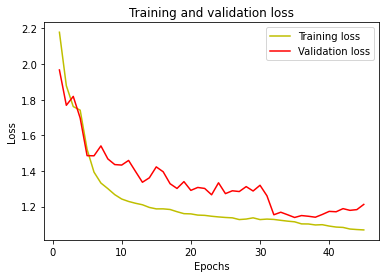

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

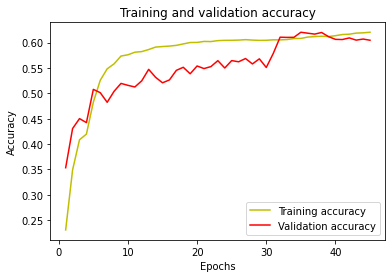

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
model.load_weights('/content/gdrive/MyDrive/Indonesia AI/CV Course/Final Project/checkpoints/uNet.hdf5')

y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

from keras.metrics import MeanIoU
n_classes = 12
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print('Mean IoU: ', IOU_keras.result().numpy())

3/3 [==============================] - 0s 91ms/step
Mean IoU:  0.1314754


# **4. Testing**

1/1 [==============================] - 0s 133ms/step


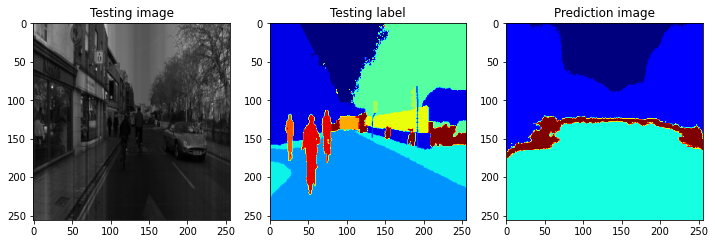

In [33]:
test_img = X1[12]
ground_truth = y1[12]
test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12,8))
plt.subplot(231)
plt.title('Testing image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction image')
plt.imshow(predicted_img, cmap='jet')
plt.show()